<a href="https://colab.research.google.com/github/bryaanabraham/Election-Data-Analysis/blob/main/Election_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies

In [197]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

###Data Extraction:
- The following snippet is a function to extract data from the provided url.
- The data is exctracted and saved to a file named as per your choice

In [198]:
def extract_data(url, name):
  response = requests.get(url)
  html_content = response.content

  # # HTML content for debugging
  # print(f"HTML content for {name}: {html_content[:1000]}")
  soup = BeautifulSoup(html_content, 'html.parser')

  table = soup.find('table', class_='table table-striped table-bordered')

  if table is None:
      print(f"Table not found for URL: {url}")
      return None

  headers = [header.text.strip() for header in table.find_all('th')]
  headers = headers[:7]
  headers.append('Source')
  print(f"Headers for {name}: {headers}")

  rows = []
  for row in table.find('tbody').find_all('tr'):
      cells = row.find_all('td')
      row_data = [cell.text.strip() for cell in cells[:7]]
      row_data.append(name)
      rows.append(row_data)

  df = pd.DataFrame(rows, columns=headers)
  print('---------------------------------------------------------------------------------------------------------------------------------------------------')
  return df

# Web Scraping

### 1. WebScrape funtion
- the web scrape funtion is designed to perfrom heirachical scraping to extract data from links within links as needed
- it returns a set of urs

### 2. Initial Fetch
- data is extracted from the given url using Beautiful Soup
- Unique links are stored in a set named urls

### 3. Next Page Navigations
- data of foloowing pages needs to be extracted (Heirachical)
- the list of urls from the initial fetch are fed into the WebScrape function for the same
- result is store in a nav_urls set
 - We can derive the relevant urls and exclude promotions and advertisements by analysing the set

In [199]:
# WebScrape Function [1]
def webScrape(links):
    unique_urls = set()
    for link in links:
        try:
            response = requests.get(link)
            html_content = response.content
            soup = BeautifulSoup(html_content, 'html.parser')

            # Extract all links from buttons
            buttons = soup.find_all('a')
            urls = {button['href'] for button in buttons if 'href' in button.attrs}
            unique_urls.update(urls)
            for url in urls:
                if 'https://results.eci.gov.in' in url:
                    if url not in unique_urls:
                        unique_urls.add(url)
                        # Recursively scrape the new URL
                        unique_urls.update(webScrape([url]))

        except Exception as e:
            print(f"Unable to fetch {link} : {e}")

    return unique_urls

In [200]:
# Initial Fetch [2]
home_url = ['https://results.eci.gov.in']
nav_from_urls = webScrape(home_url)
for link in nav_from_urls:
    print(link)

https://results.eci.gov.in/AcResultGen2ndJune2024/index.htm
https://play.google.com/store/apps/details?id=com.eci.citizen
https://results.eci.gov.in/AcResultByeJune2024/
https://results.eci.gov.in/AcResultGenJune2024/index.htm
https://results.eci.gov.in/PcResultGenJune2024/index.htm
https://apps.apple.com/in/app/voter-helpline/id1456535004
index.htm


In [201]:
# excluding false positives (removing unneeded links)
nav_from_urls = [item for item in nav_from_urls if 'results.eci.gov' in item]
for link in nav_from_urls:
    print(link)
print(f"Total Links: {len(nav_from_urls)}")

https://results.eci.gov.in/AcResultGen2ndJune2024/index.htm
https://results.eci.gov.in/AcResultByeJune2024/
https://results.eci.gov.in/AcResultGenJune2024/index.htm
https://results.eci.gov.in/PcResultGenJune2024/index.htm
Total Links: 4


In [202]:
# Next page navigations [3]
next_nav_urls = webScrape(nav_from_urls)

In [203]:
for link in next_nav_urls:
    print(link)
print(len(next_nav_urls))


candidateswise-S04195.htm
#
partywisewinresultState-1420.htm
candidateswise-S0837.htm
partywisewinresultState-911.htm
candidateswise-S0683.htm
candidateswise-S2562.htm
candidateswise-S0821.htm
candidateswise-S237.htm
partywisewinresultState-3165.htm
partywisewinresultState-860.htm
candidateswise-S22233.htm
candidateswise-S24292.htm
candidateswise-S0818.htm
partywisewinresultState-1888.htm
candidateswise-S25113.htm
partywisewinresultState-664.htm
candidateswise-S24173.htm
partywisewinresultState-582.htm
partywisewinresultState-805.htm
candidateswise-S0626.htm
candidateswise-S24136.htm
partywisewinresultState-1.htm
partywiseresult-S02.htm
hi/index.htm
https://results.eci.gov.in/AcResultByeJune2024/index.htm
partywisewinresultState-3620.htm
candidateswise-S0839.htm
partywisewinresultState-3529.htm
https://results.eci.gov.in/AcResultGenJune2024/index.htm
partywisewinresultState-1658.htm
candidateswise-S06108.htm
partywisewinresultState-140.htm
partywisewinresultState-547.htm
index.htm
can

    Relevant Links:
    - AcResultGenJune
    - AcResultByeJune
    - Party Wise result
    - Candidate wise result
  
Links need to be further analysed to see if they hold more data in the next pages whereas domain names can be be extracted <br>(This is subjective to Websites, this was discovered upon exploration)

# Heirarchical Extraction

- this is the process of choosing to scrape for more links from a website or extracting data or simply ignoring
- on WebScrape the set includes links and domain names
- the domain names consist tabular data (subjective to website)
- the links navigate to other websites which contain data or more links(only some of which need to be analysed)
- Item is chosen for subscraping or extraction based on the list of relevant links (substrings)

In [204]:
# Directory to store Files
import os
os.makedirs('csv_files', exist_ok=True)
location = 'csv_files'

In [205]:
relevant_address = 'https://results.eci.gov.in'
relevant_domain_names = ['partywisewinresultState','candidateswise', ]

In [206]:
def save2csv(df, name, location):
  csv_file_path = f"{location}/{name}.csv"
  df.to_csv(csv_file_path, index=False)

In [207]:
# Hierarchical Extraction
for url in list(next_nav_urls):

  for relevant in relevant_domain_names:
    if relevant in url:

      if relevant == 'partywisewinresultState':
        df = pd.DataFrame()
        base_url = "https://results.eci.gov.in/PcResultGenJune2024/"
        url = base_url + '/' + url
        name = url.split('-')[-1].split('.')[0]
        df_new = extract_data(url, name)
        if df_new is not None:
            df_gen_party = pd.concat([df, df_new], ignore_index=True)

      if relevant == 'candidateswise':
        df = pd.DataFrame()
        base_url = "https://results.eci.gov.in/AcResultByeJune2024"
        url = base_url + '/' + url
        url = url.replace('candidateswise-', 'Constituencywise')
        name = url.split('-')[-1].split('.')[0]
        df_bye_new = extract_data(url, name)
        if df_bye_new is not None:
            df_bye_candidate = pd.concat([df, df_bye_new], ignore_index=True)


Headers for https://results: ['S.N.', 'Candidate', 'Party', 'EVM Votes', 'Postal Votes', 'Total Votes', '% of Votes', 'Source']
---------------------------------------------------------------------------------------------------------------------------------------------------
Headers for 1420: ['S.No', 'Parliament Constituency', 'Winning Candidate', 'Total Votes', 'Margin', 'Source']
---------------------------------------------------------------------------------------------------------------------------------------------------
Headers for https://results: ['S.N.', 'Candidate', 'Party', 'EVM Votes', 'Postal Votes', 'Total Votes', '% of Votes', 'Source']
---------------------------------------------------------------------------------------------------------------------------------------------------
Headers for 911: ['S.No', 'Parliament Constituency', 'Winning Candidate', 'Total Votes', 'Margin', 'Source']
---------------------------------------------------------------------------------

In [208]:
df_bye_candidate.head()

,S.N.,Candidate,Party,EVM Votes,Postal Votes,Total Votes,% of Votes,Source
0,1,TARLOCHAN SINGH,Indian National Congress,53231,233,53464,35.13,https://results
1,2,NAYAB SINGH,Bharatiya Janata Party,94714,290,95004,62.43,https://results
2,3,RAJINDER,Jannayak Janta Party,1072,1,1073,0.71,https://results
3,4,TILAK RAJ SINGLA,Rashtriya Garib Dal,331,0,331,0.22,https://results
4,5,ROHATASH,Rashtriya Mazdoor Ekta Party,252,0,252,0.17,https://results


In [209]:
df_gen_party.head()

,S.No,Parliament Constituency,Winning Candidate,Total Votes,Margin,Source
0,1,Kairana(2),IQRA CHOUDHARY,528013,69116,1680
1,2,Muzaffarnagar(3),HARENDRA SINGH MALIK,470721,24672,1680
2,3,Moradabad(6),RUCHI VIRA,637363,105762,1680
3,4,Rampur(7),MOHIBBULLAH,481503,87434,1680
4,5,Sambhal(8),ZIA UR REHMAN,571161,121494,1680


In [210]:
save2csv(df_bye_candidate,'candidate_wise',location)

In [211]:
save2csv(df_gen_party,'party_wise',location)

# Manual Extraction (State Wise)
- some links are opened dynamically and require manual exctraction
- to access the state data from the drop down menu i have inspected the website
- html_content refers to the html code behind the drop down menu which was used to get the statewise links
- base url was set by navigating to the website and checking the reuqired url

In [212]:
# html content was extracted from inspecting (CNTRL+SHIFT+I) the website
html_content = """
<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>Election Commission of India</title>
</head>
<body>
  <div class="custom-tabs">
    <div class="container-fluid">
      <div class="row">
        <div class="col-12">
          <div class="card custom-card shadow-sm">
            <div class="card-header custom-header">
              <h5 class="mb-0">General Election to Parliamentary Constituencies: Trends & Results June-2024</h5>
            </div>
            <div class="filter-btns">
              <select id="ctl00_ContentPlaceHolder1_Result1_ddlState" class="form-select" onchange="return GetResult(this)" name="state">
                <option value="">Select State Wise</option>
                <option value="U01">Andaman & Nicobar Islands</option>
                <option value="S01">Andhra Pradesh</option>
                <option value="S02">Arunachal Pradesh</option>
                <option value="S03">Assam</option>
                <option value="S04">Bihar</option>
                <option value="U02">Chandigarh</option>
                <option value="S26">Chhattisgarh</option>
                <option value="U03">Dadra & Nagar Haveli and Daman & Diu</option>
                <option value="S05">Goa</option>
                <option value="S06">Gujarat</option>
                <option value="S07">Haryana</option>
                <option value="S08">Himachal Pradesh</option>
                <option value="U08">Jammu and Kashmir</option>
                <option value="S27">Jharkhand</option>
                <option value="S10">Karnataka</option>
                <option value="S11">Kerala</option>
                <option value="U09">Ladakh</option>
                <option value="U06">Lakshadweep</option>
                <option value="S12">Madhya Pradesh</option>
                <option value="S13">Maharashtra</option>
                <option value="S14">Manipur</option>
                <option value="S15">Meghalaya</option>
                <option value="S16">Mizoram</option>
                <option value="S17">Nagaland</option>
                <option value="U05">Delhi</option>
                <option value="S18">Odisha</option>
                <option value="U07">Puducherry</option>
                <option value="S19">Punjab</option>
                <option value="S20">Rajasthan</option>
                <option value="S21">Sikkim</option>
                <option value="S22">Tamil Nadu</option>
                <option value="S29">Telangana</option>
                <option value="S23">Tripura</option>
                <option value="S24">Uttar Pradesh</option>
                <option value="S28">Uttarakhand</option>
                <option value="S25">West Bengal</option>
              </select>
            </div>
            <div class="card-body">
            </div>
          </div>
        </div>
      </div>
    </div>
  </div>
</body>
</html>
"""

soup = BeautifulSoup(html_content, 'html.parser')
select = soup.find('select', {'id': 'ctl00_ContentPlaceHolder1_Result1_ddlState'})

base_url = "https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-"
options = select.find_all('option')
state_links = {option.text: base_url + option['value'] for option in options if option['value']}

for state, link in state_links.items():
  print(f"{state}: {link}")


Andaman & Nicobar Islands: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-U01
Andhra Pradesh: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S01
Arunachal Pradesh: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S02
Assam: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S03
Bihar: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S04
Chandigarh: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-U02
Chhattisgarh: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S26
Dadra & Nagar Haveli and Daman & Diu: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-U03
Goa: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S05
Gujarat: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S06
Haryana: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S07
Himachal Pradesh: https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-S08
Jammu and Kashm

In [213]:
def extract_state_data(url, state_name):
  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  table = soup.find('table')

  df = pd.read_html(str(table))[0]
  df['State'] = state_name
  return df

In [214]:
df_state_wise = pd.DataFrame()

for state, link in state_links.items():
  df = extract_state_data(link, state)
  df_state_wise = pd.concat([df_state_wise, df], ignore_index=True)

df_state_wise.head()

,Party,Won,Leading,Total,State
0,Bharatiya Janata Party - BJP,1,0,1,Andaman & Nicobar Islands
1,Total,1,0,1,Andaman & Nicobar Islands
2,Telugu Desam - TDP,16,0,16,Andhra Pradesh
3,Yuvajana Sramika Rythu Congress Party - YSRCP,4,0,4,Andhra Pradesh
4,Bharatiya Janata Party - BJP,3,0,3,Andhra Pradesh


In [215]:
save2csv(df_state_wise,'state_wise',location)

# Save all relevant data

In [216]:
import shutil

directory_to_compress = '/content/csv_files'
output_zip_file = '/content/csv_files.zip'
shutil.make_archive(output_zip_file.replace('.zip', ''), 'zip', directory_to_compress)

'/content/csv_files.zip'

# Data Visualization

In [217]:
# @title df_bye_candidate
df_bye_candidate.head()

,S.N.,Candidate,Party,EVM Votes,Postal Votes,Total Votes,% of Votes,Source
0,1,TARLOCHAN SINGH,Indian National Congress,53231,233,53464,35.13,https://results
1,2,NAYAB SINGH,Bharatiya Janata Party,94714,290,95004,62.43,https://results
2,3,RAJINDER,Jannayak Janta Party,1072,1,1073,0.71,https://results
3,4,TILAK RAJ SINGLA,Rashtriya Garib Dal,331,0,331,0.22,https://results
4,5,ROHATASH,Rashtriya Mazdoor Ekta Party,252,0,252,0.17,https://results


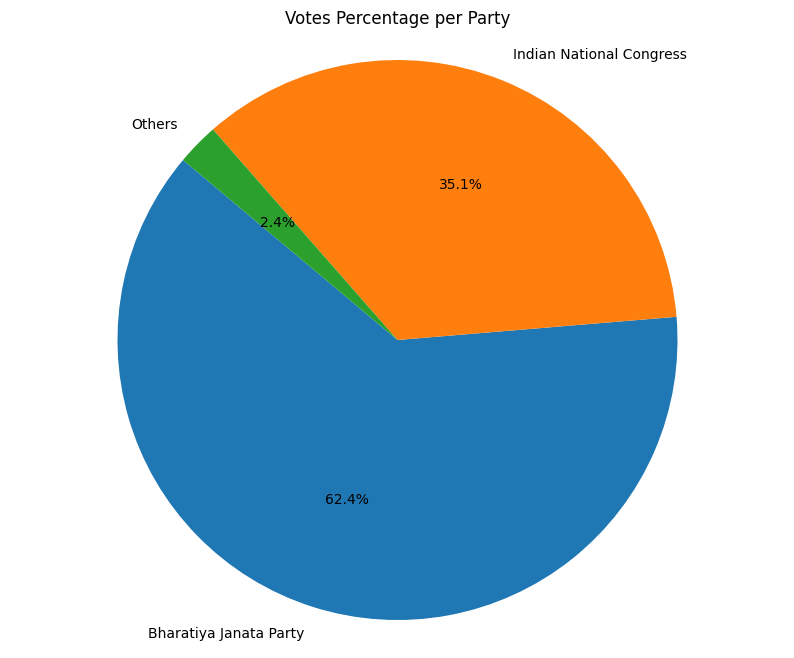

In [227]:
# @title Party-Total Vote Pi Chart

df_bye_candidate['Total Votes'] = pd.to_numeric(df_bye_candidate['Total Votes'], errors='coerce')

# Aggregate votes per party
party_votes = df_bye_candidate.groupby('Party')['Total Votes'].sum().sort_values(ascending=False)

total_votes = party_votes.sum()
party_percentages = party_votes / total_votes * 100

# Filter parties with less than 1% votes
other_votes = party_percentages[party_percentages < 1].sum()
party_percentages_filtered = party_percentages[party_percentages >= 1]
party_percentages_filtered['Others'] = other_votes

plt.figure(figsize=(10, 8))
plt.pie(party_percentages_filtered, labels=party_percentages_filtered.index, autopct='%1.1f%%', startangle=140)
plt.title('Votes Percentage per Party')
plt.axis('equal')
plt.show()

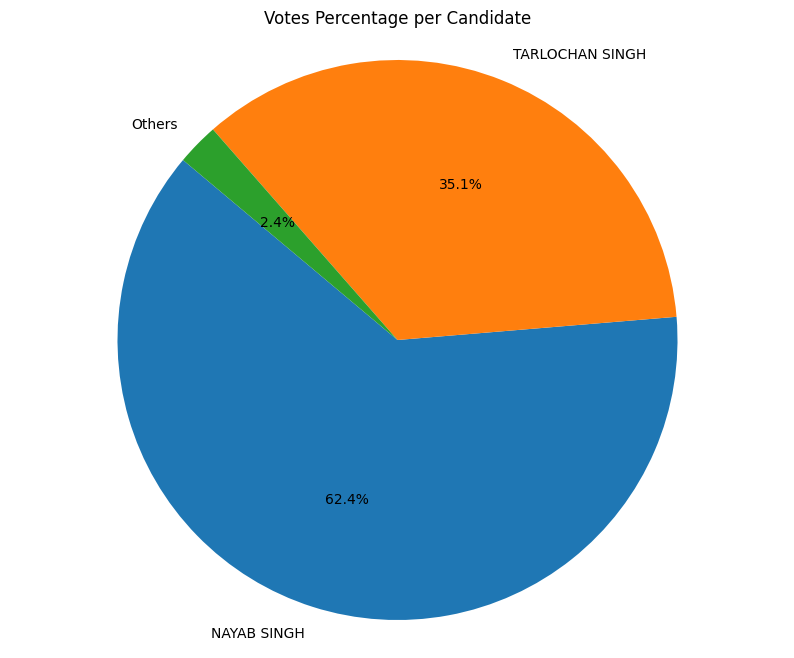

In [219]:
# @title Candidate-Vote Pi Chart
df_bye_candidate['Total Votes'] = pd.to_numeric(df_bye_candidate['Total Votes'], errors='coerce')

# Aggregate votes per candidate
party_votes = df_bye_candidate.groupby('Candidate')['Total Votes'].sum().sort_values(ascending=False)

total_votes = party_votes.sum()
party_percentages = party_votes / total_votes * 100

# Filter Candidates with less than 1% votes
other_votes = party_percentages[party_percentages < 1].sum()
party_percentages_filtered = party_percentages[party_percentages >= 1]
party_percentages_filtered['Others'] = other_votes

plt.figure(figsize=(10, 8))
plt.pie(party_percentages_filtered, labels=party_percentages_filtered.index, autopct='%1.1f%%', startangle=140)
plt.title('Votes Percentage per Candidate')
plt.axis('equal')
plt.show()

In [220]:
# @title df_gen_party
df_gen_party.head()

,S.No,Parliament Constituency,Winning Candidate,Total Votes,Margin,Source
0,1,Kairana(2),IQRA CHOUDHARY,528013,69116,1680
1,2,Muzaffarnagar(3),HARENDRA SINGH MALIK,470721,24672,1680
2,3,Moradabad(6),RUCHI VIRA,637363,105762,1680
3,4,Rampur(7),MOHIBBULLAH,481503,87434,1680
4,5,Sambhal(8),ZIA UR REHMAN,571161,121494,1680


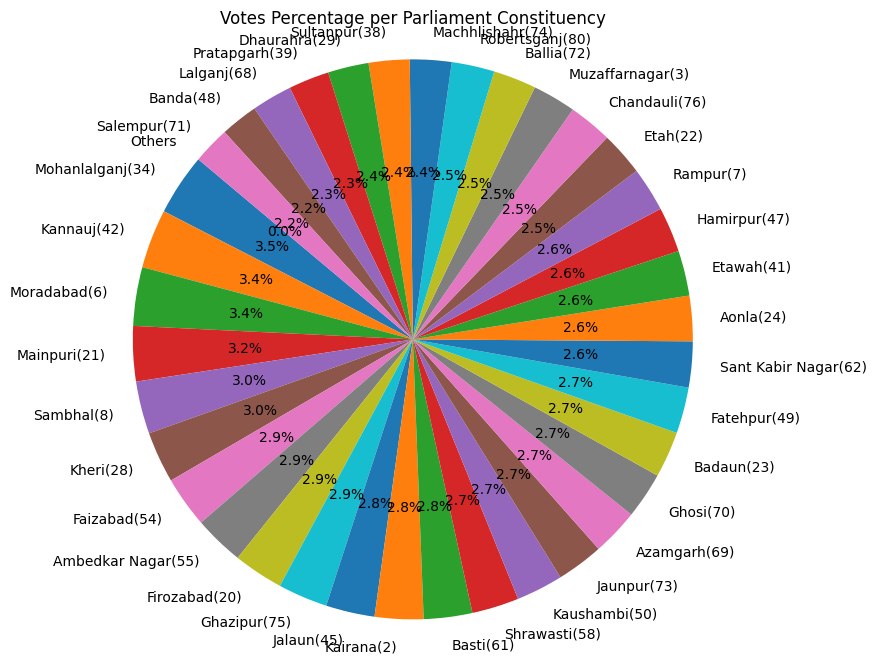

In [226]:
# @title Parliament Constituency-Vote Pi Chart
df_gen_party['Total Votes'] = pd.to_numeric(df_gen_party['Total Votes'], errors='coerce')

# Aggregate votes per Constituency
contituency_votes = df_gen_party.groupby('Parliament Constituency')['Total Votes'].sum().sort_values(ascending=False)

total_votes = contituency_votes.sum()
constituency_percentages = contituency_votes / total_votes * 100

# Filter  with less than 1% votes
other_votes = constituency_percentages[constituency_percentages < 1].sum()
constituency_percentages_filtered = constituency_percentages[constituency_percentages >= 1]
constituency_percentages_filtered['Others'] = other_votes

plt.figure(figsize=(10, 8))
plt.pie(constituency_percentages_filtered, labels=constituency_percentages_filtered.index, autopct='%1.1f%%', startangle=140)
plt.title('Votes Percentage per Parliament Constituency')
plt.axis('equal')
plt.show()

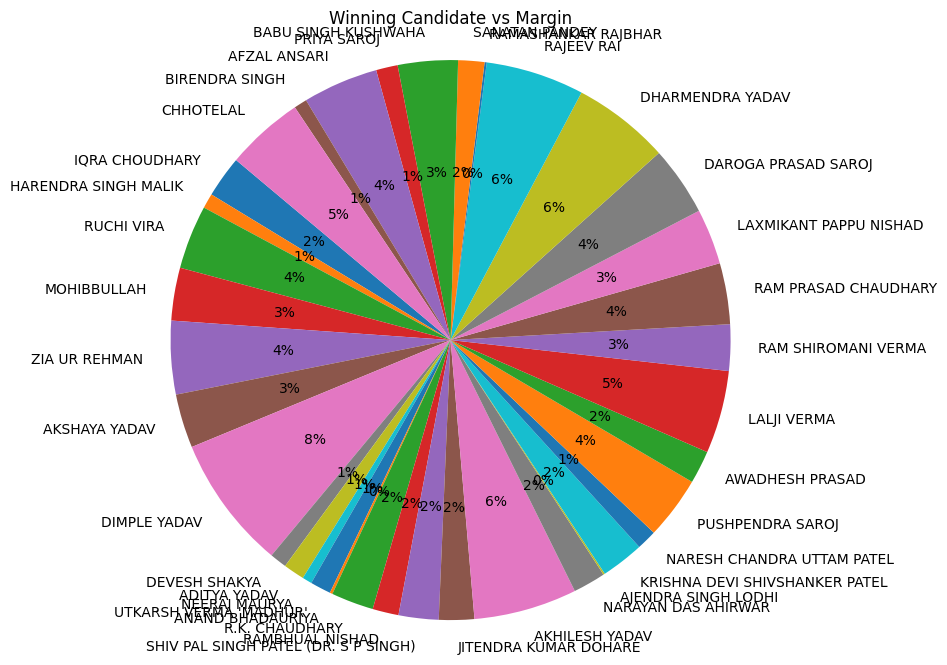

In [222]:
# @title Winning Candidate-Margin Pi Chart
plt.figure(figsize=(10, 8))
plt.pie(df_gen_party['Margin'], labels=df_gen_party['Winning Candidate'], autopct='%1.0f%%', startangle=140)
plt.title('Winning Candidate vs Margin')
plt.axis('equal')
plt.show()

In [223]:
# @title df_state_wise
df_state_wise.head()

,Party,Won,Leading,Total,State
0,Bharatiya Janata Party - BJP,1,0,1,Andaman & Nicobar Islands
1,Total,1,0,1,Andaman & Nicobar Islands
2,Telugu Desam - TDP,16,0,16,Andhra Pradesh
3,Yuvajana Sramika Rythu Congress Party - YSRCP,4,0,4,Andhra Pradesh
4,Bharatiya Janata Party - BJP,3,0,3,Andhra Pradesh


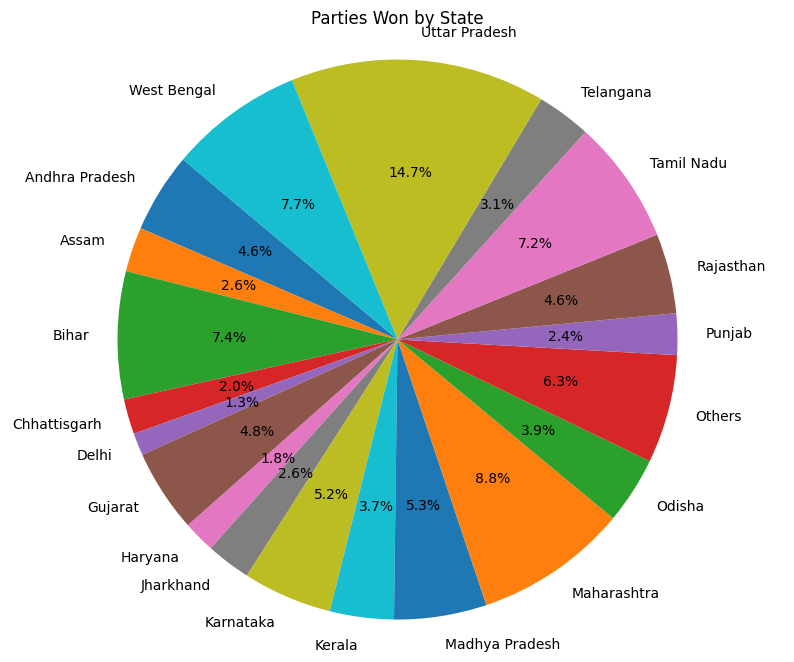

In [224]:
# @title State-Won Pi Chart
df_state_wise = df_state_wise[df_state_wise['Party'] != 'Total']

state_wise_sum = df_state_wise.groupby('State')['Won'].sum().reset_index()

state_wise_sum['Percentage'] = state_wise_sum['Won'] / state_wise_sum['Won'].sum() * 100

threshold = 1.0
state_wise_sum.loc[state_wise_sum['Percentage'] < threshold, 'State'] = 'Others'
state_wise_sum = state_wise_sum.groupby('State')['Won'].sum().reset_index()

plt.figure(figsize=(10, 8))
plt.pie(state_wise_sum['Won'], labels=state_wise_sum['State'], autopct='%1.1f%%', startangle=140)
plt.title('Parties Won by State')
plt.axis('equal')
plt.show()